In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


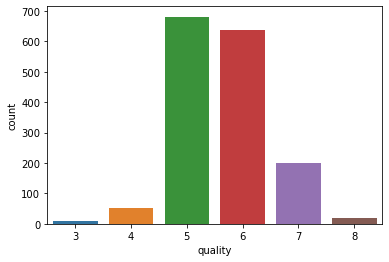

In [3]:
sns.countplot(x = 'quality', data=df)

In [4]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [5]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

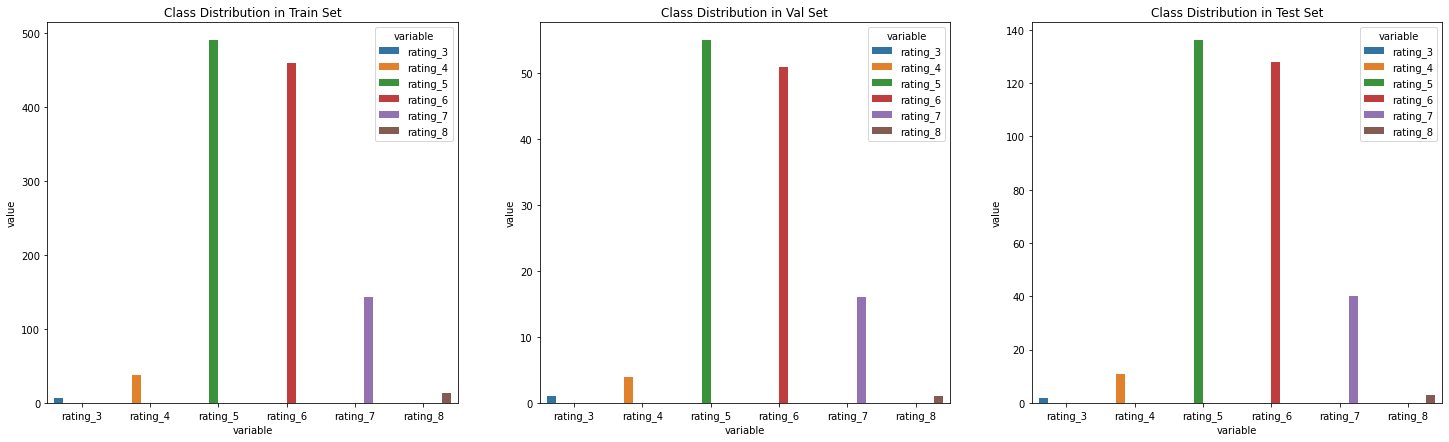

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [10]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [11]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [12]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


In [13]:
class_weights_all = class_weights[target_list]

In [14]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [15]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [16]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [17]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [21]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [23]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: \
          {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| \
          Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.40336 | Val Loss:           1.39105 | Train Acc: 52.778|           Val Acc: 49.219
Epoch 002: | Train Loss: 1.13559 | Val Loss:           1.28564 | Train Acc: 76.389|           Val Acc: 42.969
Epoch 003: | Train Loss: 1.12444 | Val Loss:           1.32182 | Train Acc: 79.167|           Val Acc: 41.406
Epoch 004: | Train Loss: 1.03011 | Val Loss:           1.36593 | Train Acc: 69.444|           Val Acc: 38.281
Epoch 005: | Train Loss: 1.01635 | Val Loss:           1.26651 | Train Acc: 81.944|           Val Acc: 39.062
Epoch 006: | Train Loss: 0.97101 | Val Loss:           1.27452 | Train Acc: 84.722|           Val Acc: 42.188
Epoch 007: | Train Loss: 0.81440 | Val Loss:           1.30518 | Train Acc: 91.667|           Val Acc: 39.844
Epoch 008: | Train Loss: 0.80332 | Val Loss:           1.34198 | Train Acc: 94.444|           Val Acc: 44.531
Epoch 009: | Train Loss: 0.92047 | Val Loss:           1.26797 | Train Acc: 91.667|           Val Acc: 42.969
Epoch 010:

Epoch 076: | Train Loss: 0.47544 | Val Loss:           1.17702 | Train Acc: 97.222|           Val Acc: 50.000
Epoch 077: | Train Loss: 0.47224 | Val Loss:           1.10222 | Train Acc: 97.222|           Val Acc: 53.906
Epoch 078: | Train Loss: 0.45491 | Val Loss:           1.01125 | Train Acc: 100.000|           Val Acc: 56.250
Epoch 079: | Train Loss: 0.41223 | Val Loss:           1.11882 | Train Acc: 100.000|           Val Acc: 54.688
Epoch 080: | Train Loss: 0.52148 | Val Loss:           1.02974 | Train Acc: 97.222|           Val Acc: 57.031
Epoch 081: | Train Loss: 0.45510 | Val Loss:           1.17177 | Train Acc: 100.000|           Val Acc: 53.125
Epoch 082: | Train Loss: 0.45834 | Val Loss:           1.11081 | Train Acc: 100.000|           Val Acc: 54.688
Epoch 083: | Train Loss: 0.50868 | Val Loss:           1.14883 | Train Acc: 100.000|           Val Acc: 56.250
Epoch 084: | Train Loss: 0.47402 | Val Loss:           1.12647 | Train Acc: 95.833|           Val Acc: 55.469
Epoch

Epoch 151: | Train Loss: 0.42168 | Val Loss:           1.23052 | Train Acc: 98.611|           Val Acc: 55.469
Epoch 152: | Train Loss: 0.40450 | Val Loss:           1.09085 | Train Acc: 100.000|           Val Acc: 62.500
Epoch 153: | Train Loss: 0.34613 | Val Loss:           1.13445 | Train Acc: 100.000|           Val Acc: 60.156
Epoch 154: | Train Loss: 0.36309 | Val Loss:           0.99853 | Train Acc: 100.000|           Val Acc: 64.844
Epoch 155: | Train Loss: 0.36764 | Val Loss:           1.04910 | Train Acc: 100.000|           Val Acc: 61.719
Epoch 156: | Train Loss: 0.34698 | Val Loss:           1.05037 | Train Acc: 100.000|           Val Acc: 63.281
Epoch 157: | Train Loss: 0.40668 | Val Loss:           1.16060 | Train Acc: 100.000|           Val Acc: 60.938
Epoch 158: | Train Loss: 0.44816 | Val Loss:           1.11444 | Train Acc: 98.611|           Val Acc: 62.500
Epoch 159: | Train Loss: 0.38740 | Val Loss:           1.05347 | Train Acc: 100.000|           Val Acc: 64.062
Epo

Epoch 226: | Train Loss: 0.38264 | Val Loss:           1.16475 | Train Acc: 98.611|           Val Acc: 60.938
Epoch 227: | Train Loss: 0.27693 | Val Loss:           1.09982 | Train Acc: 100.000|           Val Acc: 58.594
Epoch 228: | Train Loss: 0.36170 | Val Loss:           1.19677 | Train Acc: 98.611|           Val Acc: 60.156
Epoch 229: | Train Loss: 0.35793 | Val Loss:           1.11946 | Train Acc: 100.000|           Val Acc: 60.156
Epoch 230: | Train Loss: 0.33429 | Val Loss:           1.13754 | Train Acc: 97.222|           Val Acc: 60.156
Epoch 231: | Train Loss: 0.35517 | Val Loss:           1.22288 | Train Acc: 100.000|           Val Acc: 58.594
Epoch 232: | Train Loss: 0.31922 | Val Loss:           1.12994 | Train Acc: 100.000|           Val Acc: 57.812
Epoch 233: | Train Loss: 0.34400 | Val Loss:           1.13831 | Train Acc: 98.611|           Val Acc: 58.594
Epoch 234: | Train Loss: 0.32533 | Val Loss:           1.07610 | Train Acc: 100.000|           Val Acc: 62.500
Epoch

Epoch 300: | Train Loss: 0.33510 | Val Loss:           1.18522 | Train Acc: 100.000|           Val Acc: 58.594


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

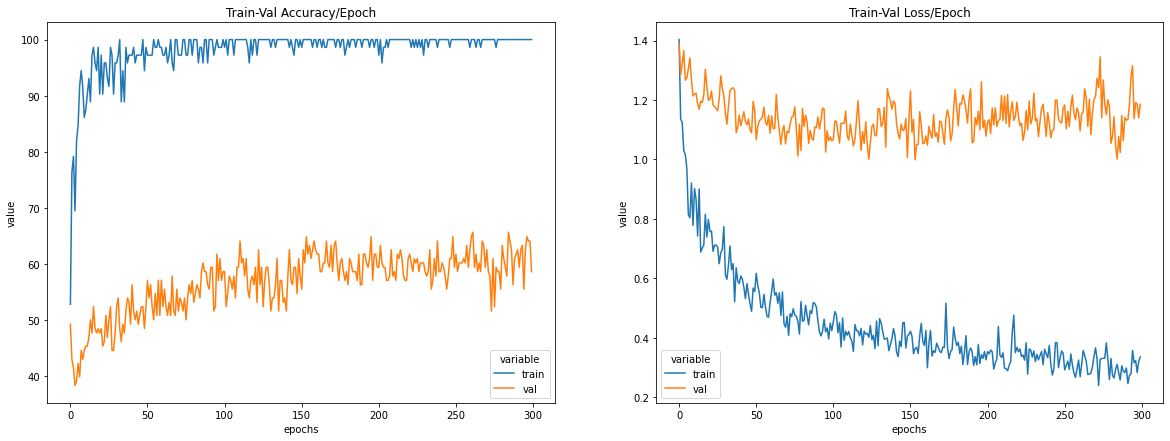

In [25]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [26]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

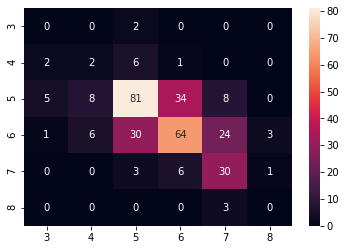

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [28]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.12      0.18      0.15        11
           2       0.66      0.60      0.63       136
           3       0.61      0.50      0.55       128
           4       0.46      0.75      0.57        40
           5       0.00      0.00      0.00         3

    accuracy                           0.55       320
   macro avg       0.31      0.34      0.32       320
weighted avg       0.59      0.55      0.56       320

